In [15]:
%load_ext autoreload
%autoreload 2

# Importy

In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from utils import *
import plotly.graph_objs as go
import plotly.express as px

# Przygotowanie danych

In [17]:
dataframes = read_csv("./datasets", 'csv')

In [18]:
res = prepare_dataframes(dataframes)

  0%|          | 0/3 [00:00<?, ?it/s]

out_hum
pressure
out_temp


In [19]:
df = get_labels(res, '2024-02-13')

In [20]:
df['rain_1h'] = df['rain_1h'].fillna(0)
df['snow_1h'] = df['snow_1h'].fillna(0)
df['total percipitation'] = df['rain_1h'] + df['snow_1h']

In [21]:
df['last_changed_count'] = df.groupby('last_changed')['last_changed'].transform('count')
df = df.drop_duplicates(subset=['last_changed'])
df = df.loc[:, ['last_changed', 'pressure', 'out_temp', 'out_hum', 'total percipitation']]
df = df.reset_index(drop=True)

## Tabela 1 (time, P, T, H, R)

In [22]:
df

,last_changed,pressure,out_temp,out_hum,total percipitation
0,2023-09-20 00:00:00+00:00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 01:00:00+00:00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 02:00:00+00:00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 03:00:00+00:00,985.280000,14.041667,81.300000,0.00
4,2023-09-20 04:00:00+00:00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...
3499,2024-02-12 19:00:00+00:00,974.777778,7.220000,85.166667,0.00
3500,2024-02-12 20:00:00+00:00,975.846154,7.020000,84.933333,0.00
3501,2024-02-12 21:00:00+00:00,976.846154,6.566667,84.033333,0.00
3502,2024-02-12 22:00:00+00:00,976.521739,6.370000,83.873913,0.00


In [23]:
df.value_counts('total percipitation')

total percipitation
0.00     2666
0.25      166
0.51      149
0.38       37
1.02       29
         ... 
1.53        1
1.59        1
1.61        1
1.66        1
30.99       1
Name: count, Length: 119, dtype: int64

## Tabela 2 (time, 0, -1, -2, -3...)

In [24]:
df2 = generate_data(df, 5)
df2

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,2023-09-20 05:00:00+00:00,0.0,986.217391,13.966667,83.366667,0.0,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 06:00:00+00:00,0.0,986.478261,14.640000,80.100000,0.0,986.217391,13.966667,83.366667,0.00,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 07:00:00+00:00,0.0,986.739130,15.480000,75.420000,0.0,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 08:00:00+00:00,0.0,986.090909,17.000000,69.840000,0.0,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,2023-09-20 09:00:00+00:00,0.0,986.200000,18.600000,61.920000,0.0,986.090909,17.000000,69.840000,0.00,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2024-02-12 18:00:00+00:00,0.0,974.642857,7.371429,84.830000,0.0,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,2024-02-12 19:00:00+00:00,0.0,974.777778,7.220000,85.166667,0.0,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,2024-02-12 20:00:00+00:00,0.0,975.846154,7.020000,84.933333,0.0,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,2024-02-12 21:00:00+00:00,0.0,976.846154,6.566667,84.033333,0.0,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


# SVR (bez normalizacji danych)

In [9]:
X = df2.iloc[:,2:]
y = df2.iloc[:,1:2]

In [10]:
X

,Press t0,Temp t0,Hum t0,rain_1h,snow_1h,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,985.666667,13.833333,83.333333,0.25,0.0,0.25,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,986.217391,13.966667,83.366667,0.00,0.0,0.00,985.666667,13.833333,83.333333,0.25,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,986.478261,14.640000,80.100000,0.00,0.0,0.00,986.217391,13.966667,83.366667,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,986.739130,15.480000,75.420000,0.00,0.0,0.00,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,986.090909,17.000000,69.840000,0.00,0.0,0.00,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,974.642857,7.371429,84.830000,0.00,0.0,0.00,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3853,974.777778,7.220000,85.166667,0.00,0.0,0.00,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3854,975.846154,7.020000,84.933333,0.00,0.0,0.00,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3855,976.846154,6.566667,84.033333,0.00,0.0,0.00,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


In [13]:
y

,TP t+1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3493,0.0
3494,0.0
3495,0.0
3496,0.0


## Test 1: Poly, RBF, C=[0.1,1,10]

In [14]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='poly', C=1, degree=1),
    SVR(kernel='poly', C=1, degree=2),
    SVR(kernel='poly', C=1, degree=3),
    SVR(kernel='poly', C=1, degree=4), 
    
    SVR(kernel='poly', C=0.1, degree=1),
    SVR(kernel='poly', C=0.1, degree=2),
    SVR(kernel='poly', C=0.1, degree=3),
    SVR(kernel='poly', C=0.1, degree=4),
    
    SVR(kernel='poly', C=10, degree=1),
    SVR(kernel='poly', C=10, degree=2),
    SVR(kernel='poly', C=10, degree=3),
    SVR(kernel='poly', C=10, degree=4),
    
    SVR(kernel='rbf', C=0.1, degree=1),
    SVR(kernel='rbf', C=0.1, degree=2),
    SVR(kernel='rbf', C=0.1, degree=3),
    SVR(kernel='rbf', C=0.1, degree=4),
    
    SVR(kernel='rbf', C=1, degree=1),
    SVR(kernel='rbf', C=1, degree=2),
    SVR(kernel='rbf', C=1, degree=3),
    SVR(kernel='rbf', C=1, degree=4),
    
    SVR(kernel='rbf', C = 10, degree=1),
    SVR(kernel='rbf', C = 10, degree=2),
    SVR(kernel='rbf', C = 10, degree=3),
    SVR(kernel='rbf', C = 10, degree=4),   
    
    SVR(kernel='rbf', C = 20, degree=1),
    SVR(kernel='rbf', C = 20, degree=2),
    SVR(kernel='rbf', C = 20, degree=3),
    SVR(kernel='rbf', C = 20, degree=4),   
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_1 = pd.DataFrame(results_list)

  0%|          | 0/28 [00:00<?, ?it/s]

In [15]:
df_svr_1

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,poly,1,1.0,"{'C': 1, 'cache_size': 200, 'coef0': 0.0, 'deg...",-0.015544,-0.976912,-0.243062
1,SVR,poly,2,1.0,"{'C': 1, 'cache_size': 200, 'coef0': 0.0, 'deg...",-0.015313,-0.976831,-0.242826
2,SVR,poly,3,1.0,"{'C': 1, 'cache_size': 200, 'coef0': 0.0, 'deg...",-0.015027,-0.976688,-0.242733
3,SVR,poly,4,1.0,"{'C': 1, 'cache_size': 200, 'coef0': 0.0, 'deg...",-0.014545,-0.976467,-0.242475
4,SVR,poly,1,0.1,"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.015626,-0.976920,-0.243206
5,SVR,poly,2,0.1,"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.015629,-0.976937,-0.243122
6,SVR,poly,3,0.1,"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.015642,-0.976943,-0.243096
7,SVR,poly,4,0.1,"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.015530,-0.976904,-0.243039
8,SVR,poly,1,10.0,"{'C': 10, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.014571,-0.976502,-0.242424
9,SVR,poly,2,10.0,"{'C': 10, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.012782,-0.975679,-0.241351


## Test 2: RBF, C=[20,50,100]

In [16]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='rbf', C = 20, degree=1),
    SVR(kernel='rbf', C = 20, degree=2),
    SVR(kernel='rbf', C = 20, degree=3),
    SVR(kernel='rbf', C = 20, degree=4), 
    
    SVR(kernel='rbf', C = 50, degree=1),
    SVR(kernel='rbf', C = 50, degree=2),
    SVR(kernel='rbf', C = 50, degree=3),
    SVR(kernel='rbf', C = 50, degree=4),  
    
    SVR(kernel='rbf', C = 100, degree=1),
    SVR(kernel='rbf', C = 100, degree=2),
    SVR(kernel='rbf', C = 100, degree=3),
    SVR(kernel='rbf', C = 100, degree=4),  
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_2 = pd.DataFrame(results_list)

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
df_svr_2

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,rbf,1,20,"{'C': 20, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.011641,-0.975108,-0.240692
1,SVR,rbf,2,20,"{'C': 20, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.011641,-0.975108,-0.240692
2,SVR,rbf,3,20,"{'C': 20, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.011641,-0.975108,-0.240692
3,SVR,rbf,4,20,"{'C': 20, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.011641,-0.975108,-0.240692
4,SVR,rbf,1,50,"{'C': 50, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.006429,-0.972524,-0.238024
5,SVR,rbf,2,50,"{'C': 50, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.006429,-0.972524,-0.238024
6,SVR,rbf,3,50,"{'C': 50, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.006429,-0.972524,-0.238024
7,SVR,rbf,4,50,"{'C': 50, 'cache_size': 200, 'coef0': 0.0, 'de...",-0.006429,-0.972524,-0.238024
8,SVR,rbf,1,100,"{'C': 100, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.000353,-0.969292,-0.235595
9,SVR,rbf,2,100,"{'C': 100, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.000353,-0.969292,-0.235595


## Test 3: RBF, C=[1e3,1e4,1e5]

In [18]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='rbf', C = 1000, degree=1),
    SVR(kernel='rbf', C = 1000, degree=2),
    SVR(kernel='rbf', C = 1000, degree=3),
    SVR(kernel='rbf', C = 1000, degree=4), 
    
    SVR(kernel='rbf', C = 10000, degree=1),
    SVR(kernel='rbf', C = 10000, degree=2),
    SVR(kernel='rbf', C = 10000, degree=3),
    SVR(kernel='rbf', C = 10000, degree=4),  
    
    SVR(kernel='rbf', C = 100000, degree=1),
    SVR(kernel='rbf', C = 100000, degree=2),
    SVR(kernel='rbf', C = 100000, degree=3),
    SVR(kernel='rbf', C = 100000, degree=4),  
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_3 = pd.DataFrame(results_list) #df_svr_3

  0%|          | 0/12 [00:00<?, ?it/s]

In [19]:
df_svr_3

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,rbf,1,1000,"{'C': 1000, 'cache_size': 200, 'coef0': 0.0, '...",0.043481,-0.944690,-0.226369
1,SVR,rbf,2,1000,"{'C': 1000, 'cache_size': 200, 'coef0': 0.0, '...",0.043481,-0.944690,-0.226369
2,SVR,rbf,3,1000,"{'C': 1000, 'cache_size': 200, 'coef0': 0.0, '...",0.043481,-0.944690,-0.226369
3,SVR,rbf,4,1000,"{'C': 1000, 'cache_size': 200, 'coef0': 0.0, '...",0.043481,-0.944690,-0.226369
4,SVR,rbf,1,10000,"{'C': 10000, 'cache_size': 200, 'coef0': 0.0, ...",0.081896,-0.924353,-0.218599
5,SVR,rbf,2,10000,"{'C': 10000, 'cache_size': 200, 'coef0': 0.0, ...",0.081896,-0.924353,-0.218599
6,SVR,rbf,3,10000,"{'C': 10000, 'cache_size': 200, 'coef0': 0.0, ...",0.081896,-0.924353,-0.218599
7,SVR,rbf,4,10000,"{'C': 10000, 'cache_size': 200, 'coef0': 0.0, ...",0.081896,-0.924353,-0.218599
8,SVR,rbf,1,100000,"{'C': 100000, 'cache_size': 200, 'coef0': 0.0,...",0.086733,-0.935713,-0.201083
9,SVR,rbf,2,100000,"{'C': 100000, 'cache_size': 200, 'coef0': 0.0,...",0.086733,-0.935713,-0.201083


## Test 4: RBF, C=[1e6,1e7,1e8]

In [20]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='rbf', C = 1e6, degree=1),
    SVR(kernel='rbf', C = 1e6, degree=2),
    SVR(kernel='rbf', C = 1e6, degree=3),
    SVR(kernel='rbf', C = 1e6, degree=4), 
    
    SVR(kernel='rbf', C = 1e7, degree=1),
    SVR(kernel='rbf', C = 1e7, degree=2),
    SVR(kernel='rbf', C = 1e7, degree=3),
    SVR(kernel='rbf', C = 1e7, degree=4),  
    
    SVR(kernel='rbf', C = 1e8, degree=1),
    SVR(kernel='rbf', C = 1e8, degree=2),
    SVR(kernel='rbf', C = 1e8, degree=3),
    SVR(kernel='rbf', C = 1e8, degree=4),  
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_4 = pd.DataFrame(results_list) 

  0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
df_svr_4

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,rbf,1,1000000.0,"{'C': 1000000.0, 'cache_size': 200, 'coef0': 0...",-0.255049,-0.998698,-0.308091
1,SVR,rbf,2,1000000.0,"{'C': 1000000.0, 'cache_size': 200, 'coef0': 0...",-0.255049,-0.998698,-0.308091
2,SVR,rbf,3,1000000.0,"{'C': 1000000.0, 'cache_size': 200, 'coef0': 0...",-0.255049,-0.998698,-0.308091
3,SVR,rbf,4,1000000.0,"{'C': 1000000.0, 'cache_size': 200, 'coef0': 0...",-0.255049,-0.998698,-0.308091
4,SVR,rbf,1,10000000.0,"{'C': 10000000.0, 'cache_size': 200, 'coef0': ...",-37.434143,-7.672448,-1.707040
5,SVR,rbf,2,10000000.0,"{'C': 10000000.0, 'cache_size': 200, 'coef0': ...",-37.434143,-7.672448,-1.707040
6,SVR,rbf,3,10000000.0,"{'C': 10000000.0, 'cache_size': 200, 'coef0': ...",-37.434143,-7.672448,-1.707040
7,SVR,rbf,4,10000000.0,"{'C': 10000000.0, 'cache_size': 200, 'coef0': ...",-37.434143,-7.672448,-1.707040
8,SVR,rbf,1,100000000.0,"{'C': 100000000.0, 'cache_size': 200, 'coef0':...",-2562.575133,-579.113835,-16.422621
9,SVR,rbf,2,100000000.0,"{'C': 100000000.0, 'cache_size': 200, 'coef0':...",-2562.575133,-579.113835,-16.422621


In [22]:
#C=1e4 
#epsilon 0.1 domyślna najlepsza

## Test 5: RBF C=[1e4, epsilon]

In [23]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='rbf', C=1e4, epsilon=1e-2), 
    SVR(kernel='rbf', C=1e4, epsilon=0.05),
    SVR(kernel='rbf', C=1e4, epsilon=0.1),
    SVR(kernel='rbf', C=1e4, epsilon=0.5),
    
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'epsilon': classifier.get_params().get('epsilon'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_5 = pd.DataFrame(results_list) 

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
df_svr_5   

,Classifier,Kernel,Degree,C,epsilon,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,rbf,3,10000.0,0.01,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.063164,-0.939939,-0.185445
1,SVR,rbf,3,10000.0,0.05,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.075731,-0.928726,-0.198864
2,SVR,rbf,3,10000.0,0.10,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.081896,-0.924353,-0.218599
3,SVR,rbf,3,10000.0,0.50,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",-0.413118,-1.035011,-0.500057


## Test 6: Poly, C=1e4, degree = [2,3..,9]

In [25]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='poly', C=1e4, degree=2),
    SVR(kernel='poly', C=1e4, degree=3), 
    SVR(kernel='poly', C=1e4, degree=4),
    SVR(kernel='poly', C=1e4, degree=5),
    SVR(kernel='poly', C=1e4, degree=6),
    SVR(kernel='poly', C=1e4, degree=7),
    SVR(kernel='poly', C=1e4, degree=8),
    SVR(kernel='poly', C=1e4, degree=9),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_6 = pd.DataFrame(results_list)

  0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
df_svr_6 #RBF najlepsze #0.082347	-0.924145	-0.218807

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,poly,2,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.089394,-0.924282,-0.211961
1,SVR,poly,3,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.086706,-0.927553,-0.208056
2,SVR,poly,4,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.082134,-0.935524,-0.206734
3,SVR,poly,5,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.075754,-0.944930,-0.206663
4,SVR,poly,6,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.048841,-0.962742,-0.211823
5,SVR,poly,7,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.058748,-0.956927,-0.212467
6,SVR,poly,8,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.052753,-0.963709,-0.220980
7,SVR,poly,9,10000.0,"{'C': 10000.0, 'cache_size': 200, 'coef0': 0.0...",0.032606,-0.965306,-0.228556


## Test 7: Poly, C=[1e3,1e5], degree = [1, 2, 3]

In [27]:
kfold = KFold(n_splits = 5)

classifiers = [    
    SVR(kernel='poly', C=1e3, degree=2),
    SVR(kernel='poly', C=1e3, degree=3), 
    SVR(kernel='poly', C=1e3, degree=4),
    
    SVR(kernel='poly', C=1e5, degree=2),
    SVR(kernel='poly', C=1e5, degree=3),
    SVR(kernel='poly', C=1e5, degree=4),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'Kernel': classifier.get_params().get('kernel'),
        'Degree': classifier.get_params().get('degree'),
        'C': classifier.get_params().get('C'),
        'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_svr_7 = pd.DataFrame(results_list)

  0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
df_svr_7 

,Classifier,Kernel,Degree,C,Params,r2,neg_mean_squared_error,neg_mean_absolute_error
0,SVR,poly,2,1000.0,"{'C': 1000.0, 'cache_size': 200, 'coef0': 0.0,...",0.054225,-0.939137,-0.224413
1,SVR,poly,3,1000.0,"{'C': 1000.0, 'cache_size': 200, 'coef0': 0.0,...",0.066315,-0.931338,-0.221817
2,SVR,poly,4,1000.0,"{'C': 1000.0, 'cache_size': 200, 'coef0': 0.0,...",0.070942,-0.929217,-0.221134
3,SVR,poly,2,100000.0,"{'C': 100000.0, 'cache_size': 200, 'coef0': 0....",0.072182,-0.943663,-0.217741
4,SVR,poly,3,100000.0,"{'C': 100000.0, 'cache_size': 200, 'coef0': 0....",0.030152,-0.942758,-0.233308
5,SVR,poly,4,100000.0,"{'C': 100000.0, 'cache_size': 200, 'coef0': 0....",-0.383630,-1.007094,-0.281190


## Grid Search

In [29]:
#from sklearn.model_selection import GridSearchCV

In [30]:
# X = df2.iloc[:,2:]
# y = df2.iloc[:,1:2]

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=0.2,
#     random_state=42,
# )

In [32]:
parameters = {
     'kernel': ['poly', 'rbf'],
     'degree': [2, 3],
     'C': [1, 10], 
     #'gamma': [1, 10],
}

In [33]:
# clf = GridSearchCV(
#       SVR(),
#       parameters,
#       scoring = 'neg_mean_squared_error',
#       cv = 3)

In [34]:
#clf.fit(X_train, y_train.values.ravel())

In [35]:
#print("Najlepsze parametry:", clf.best_params_)

In [36]:
#clf.cv_results_

In [37]:
#clf.best_score_

In [38]:
#clf.scorer_ #True?

## Model z najelspzymi hiperparametrami

In [77]:
training_set = df2[df2['time'] < '2023-12-13 22:00:00+00:00']
validation_set = df2[(df2['time'] < '2024-01-13 22:00:00+00:00') & (df2['time'] >= '2023-12-13 22:00:00+00:00')]
testing_set = df2[(df2['time'] <= '2024-02-13 22:00:00+00:00') & (df2['time'] >= '2024-01-13 22:00:00+00:00') ]

In [78]:
X_train = training_set.iloc[:,2:]
y_train = training_set.iloc[:,1:2]

X_val = validation_set.iloc[:,2:]
y_val = validation_set.iloc[:,1:2]

X_test = testing_set.iloc[:,2:]
y_test = testing_set.iloc[:,1:2]

In [79]:
len(X_train.index), len(X_val.index), len(X_test.index)

(2033, 744, 721)

In [80]:
svr = SVR(kernel='rbf', C=1e4, epsilon=0.1).fit(X_train, y_train.values.ravel())

## Ewaluacja modelu na zbiorze testowym

In [81]:
y_pred_test = svr.predict(X_test)

In [82]:
MSE = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
MAE = mean_absolute_error(y_test, y_pred_test)

 
print(
    f'Mean Squared Error: {MSE}\n',
    f'R2 coefficient: {r2}\n',
    f'MAE: {MAE}'
 )

Mean Squared Error: 2.6400570949260964
 R2 coefficient: 0.015258239358111325
 MAE: 0.32262739929962175


## Wykres predykcji na zbiorze testowym

In [83]:
y_pred = svr.predict(X_train)

In [84]:
MSE = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
MAE = mean_absolute_error(y_train, y_pred)
 
print(
    f'Mean Squared Error: {MSE}\n',
    f'R2 coefficient: {r2}\n',
    f'MAE: {MAE}',
 )

Mean Squared Error: 0.5994643799408416
 R2 coefficient: 0.09702904587074868
 MAE: 0.20428600127645788


In [85]:
y_pred_test = pd.DataFrame(y_pred_test, columns  = ['Predicted TP'])

In [86]:
y_test = y_test.reset_index(drop=True)

In [87]:
results2 = pd.concat([y_pred_test, y_test], axis=1)

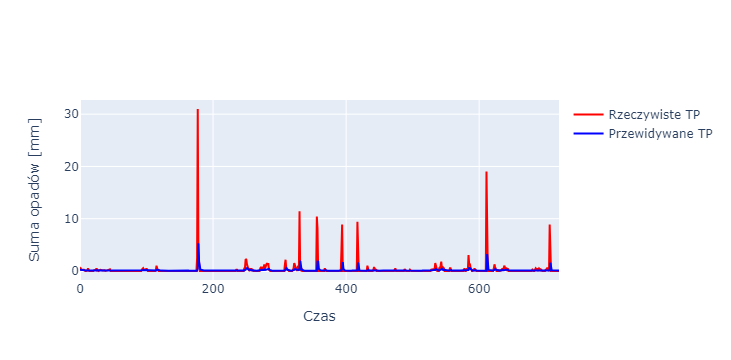

In [88]:
trace1 = go.Scatter(
    x=results.index, y=results2['TP t+1'], mode='lines', name='Rzeczywiste TP', line=dict(color='red')
)
trace2 = go.Scatter(
    x=results.index, y=results2['Predicted TP'], mode='lines', name='Przewidywane TP', line=dict(color='blue')
)

fig = go.Figure()

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_layout(
    xaxis_title='Czas',
    yaxis_title='Suma opadów [mm]')

fig.show()

## Ewaluacja modelu na zbiorze waldacyjnym

In [89]:
y_pred_val = svr.predict(X_val)

In [90]:
MSE = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
MAE = mean_absolute_error(y_val, y_pred_val)
    
print(
    f'Mean Squared Error: {MSE}\n',
    f'R2 coefficient: {r2}\n',
    f'MAE: {MAE}'
 )

Mean Squared Error: 0.10920372614141681
 R2 coefficient: 0.16864222838014797
 MAE: 0.1586012170543966


## Wykres predykcji na zbiorze walidacyjnym

In [91]:
y_pred_val = pd.DataFrame(y_pred_val, columns  = ['Predicted TP'])

In [92]:
y_val = y_val.reset_index(drop=True)

In [93]:
results = pd.concat([y_pred_val, y_val], axis=1)

In [94]:
results

,Predicted TP,TP t+1
0,0.114705,0.00
1,0.105848,0.00
2,0.098968,0.00
3,0.092279,0.00
4,0.085862,0.25
...,...,...
739,0.128043,4.57
740,0.876826,0.24
741,0.298383,0.37
742,0.220329,0.37


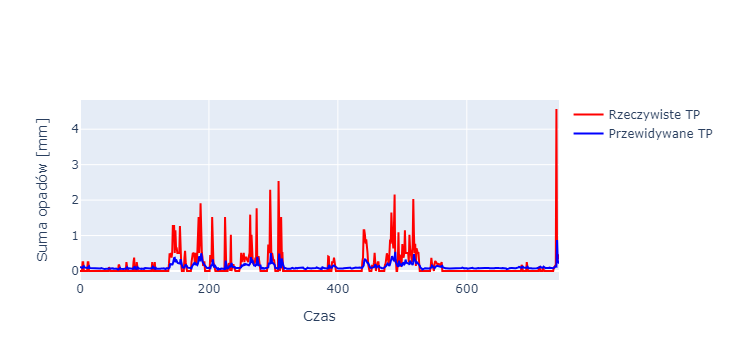

In [95]:
trace1 = go.Scatter(
    x=results.index, y=results['TP t+1'], mode='lines', name='Rzeczywiste TP', line=dict(color='red')
)
trace2 = go.Scatter(
    x=results.index, y=results['Predicted TP'], mode='lines', name='Przewidywane TP', line=dict(color='blue')
)

fig = go.Figure()

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_layout(
    xaxis_title='Czas',
    yaxis_title='Suma opadów [mm]')

fig.show()